In [1]:
# Copyright (c) 2017, Zhenwen Dai and Matthias Seeger
# Licensed under the BSD 3-clause license (see LICENSE)

# Bayesian Linear Model Example for Auto-Differentiating Linear Algebra on MXNet

###  Zhenwen Dai and Matthias Seeger
### 2017.10.9

The purpose of this notebook is to demonstrate the derived linear albebra operators in the example of Bayesian Linear Regression. The example based on the symbolic expression defined in the paper and extended with a GPy-based model framework that handles parameter transformation (positive constraints) and gradient-based optimization.

$$
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\vth}{\mathbf{\theta}}
\newcommand{\mxa}{\mathbf{A}}
\newcommand{\mxk}{\mathbf{K}}
\newcommand{\mxx}{\mathbf{X}}
\newcommand{\mxl}{\mathbf{L}}
\newcommand{\mxm}{\mathbf{M}}
\newcommand{\mxb}{\mathbf{B}}
\newcommand{\mxq}{\mathbf{Q}}
\newcommand{\mxsigma}{\mathbf{\Sigma}}
\newcommand{\Id}{\mathbf{I}}
\newcommand{\R}{\mathbb{R}}
$$

The linear regression problem, also known as least squares estimation, is a cornerstone of applied mathematics. The gold-standard approach to solving the corresponding normal equations is applying the LQ decomposition (or its transpose, the QR decomposition). Here, we focus on *Bayesian linear regression*, which is closely related to $\ell_2$ regularized least squares estimation.

Data $\{ (\vx_i, y_i)\; |\; i=1,\dots,n\}$, $y_i\in\R$, is fitted with $f(\vx) = \vx^\top\vw$, a linear function in the weight vector $\vw\in\R^d$. The input vector $\vx\in\R^d$ consists of features, describing the data case. We assume Gaussian noise on the observed targets: $y_i\sim N(\vx_i^\top\vw,\lambda_y)$. The feature map $\vx$ may depend on hyper-parameters $\vth$ (so that $\vx = \vx(\vth)$). In Bayesian linear regression (BLR), we place a prior distribution on the weigths: $\vw\sim N(0, \lambda_w\Id_d)$. If the feature vectors $\vx_i$ are collected as columns in $\mxx\in\R^{d\times n}$, the model is given by prior and likelihood:
$$
  P(\vw) = N(0, \lambda_w\Id_d),\quad P(\vy|\vw) = N(\vy |
  \mxx^\top\vw, \lambda_y\Id_n),\quad \vy=[y_1,\dots,y_n]^\top.
$$
We show how to learn hyper-parameters $\vth$, $\lambda_y$, $\lambda_w$ by maximizing the marginal likelihood
$$
  P(\vy) = N(\vy | 0,\mxsigma_y),\quad \mxsigma_y = \lambda_w
  \mxx^\top\mxx + \lambda_y\Id_n.
$$
The learning criterion is
$$
  \phi = -\log P(\vy) \doteq \frac{1}2\left( \log|2\pi\mxsigma_y| +
  \vy^\top\mxsigma_y^{-1}\vy \right).
$$
Define $\alpha := \lambda_w/\lambda_y$. We have that
$$
  \log|\mxsigma_y| - n\log(2\pi\lambda_y) = \log|\Id_n + \alpha\mxx^\top\mxx|
  \stackrel{!}{=} \log|\mxm{}|,\quad \mxm := \Id_d + \alpha\mxx\mxx^\top.
$$
Here, we use a well-known determinant identity. Moreover, the Woodbury identity gives
$$
  \mxsigma_y^{-1} = \lambda_y^{-1}\left( \Id_n - \alpha\mxx^\top\mxm^{-1}
  \mxx \right).
$$
Define the matrix
$$
  \mxb = [\mxb_1\, \mxb_2]\in\R^{d\times (n+d)},\quad \mxb{1}=\Id_d,\;
  \mxb_2 = \alpha^{1/2}\mxx.
$$
Note that $\mxb\mxb^\top = \mxm$. At this point, we use the LQ decomposition:
$$
  \mxb = \mxl\mxq,\quad \mxq = [\mxq_1\, \mxq_2],\quad
  \mxq\mxq^\top = \Id_d.
$$
Then:
$$
  \log|\mxsigma_y| - n\log(2\pi\lambda_y) = \log|\mxm| =
  \log|\mxl\mxl^\top| = 2\log|\mxl|.
$$
Also:
$$
  \mxb^\top\mxm^{-1}\mxb = \mxq^\top\mxl^\top\mxm^{-1}\mxl\mxq =
  \mxq^\top\mxq,
$$
so that
$$
  \mxsigma_y^{-1} = \lambda_y^{-1}\left( \Id_n - \mxb_2^\top\mxm^{-1}
  \mxb_2 \right) = \lambda_y^{-1}\left( \Id_n - \mxq_2^\top\mxq_2 \right).
$$
The learning criterion becomes
$$
  \phi = \frac{1}2\left( 2\log|\mxl| + n\log(2\pi\lambda_y) + \lambda_y^{-1}\left(
  \|\vy\|^2 - \|\mxq_2\vy\|^2 \right) \right).
$$

## Bayesian Linear Regression on MXNet

Here we implement the Bayesian Linear Regression (BLR) with the operator defined in the paper.

In [1]:
import os
os.environ['MXNET_ENGINE_TYPE'] =  'NaiveEngine'
import numpy as np
import mxnet as mx
import GPy
import paramz
from pylab import *
%matplotlib inline

First, we define a visualization helper function that plots a function with shadowed area indicating the confidence interval.

In [2]:
# Visualization Utility Functions
def ax_default(fignum, ax):
    if ax is None:
        fig = figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol,linewidth=0.2,ax=axes))
    plots.append(meanplot(x, lower,color=edgecol,linewidth=0.2,ax=axes))

    return plots



Second, we define some MXNet helper functions that take care of defining and binding MXNet symbols.

In [3]:
# MXNet Helper functions

def bind_mxnet_function(var, ctx, mx_params, mx_params_grad, comp_grad=True,shared_exec=None, ex_shapes=None, ex_types=None):
    """Bind a MXNet symbol with pre-specified memories.
    
    :param var: The target MXNet symbol
    :param ctx: The MXNet context where the binding happens
    :param mx_params: The dict of MXNet ndarray, which will be associated with the symbols having the same names. 
    :param mx_params_grad: The dict of MXNet ndarray, which will be associated with the gradients of the symbols having the same names.
    :param comp_grad: boolean, whether to compute the gradients
    :param ex_shapes: dict, the extra shape information that are necessary for binding
    :param ex_types: dict, the extra type information that are necessary for binding
    """
    # Bind logL
    arg_names = var.list_arguments()
    inf_shapes = var.infer_shape() if ex_shapes is None else var.infer_shape(**ex_shapes)
    inf_dtypes = var.infer_type() if ex_types is None  else var.infer_type(**ex_types)
    args = {}
    grads = {}
    for i in range(len(arg_names)):
        arg = arg_names[i]
        found = False
        if arg in mx_params:
            args[arg] = mx_params[arg]
            found = True
        if arg in mx_params_grad:
            grads[arg] = mx_params_grad[arg]
        if not found:
            args[arg] = mx.nd.empty(inf_shapes[0][i],ctx=ctx,dtype=inf_dtypes[0][i])
    aux_states = [mx.nd.empty(inf_shapes[2][i],ctx=ctx,dtype=inf_dtypes[2][i]) for i in range(len(inf_shapes[2]))]
    if comp_grad:
        var_executor = var.bind(ctx=ctx,args=args, aux_states=aux_states,args_grad=grads,grad_req='write',shared_exec=shared_exec)
    else:
        var_executor = var.bind(ctx=ctx,args=args, aux_states=aux_states, grad_req='null',shared_exec=shared_exec)
    return var_executor

def mat_eye_symbol(n, dtype=np.float32):
    """Creates n-by-n identity matrix, shape (n, n)

    :param n: Matrix size
    :param dtype: Data type (float32 or float64)
    :return: n-by-n identity matrix
    """

    index = mx.sym.arange(
        start=0, stop=n, step=1, dtype='int32')
    # Shape: (n, n)
    return mx.sym.one_hot(index, depth=n, dtype=dtype)

def extract_diag_symbol(mat, n):
    """Extracts diagonal from square matrix
    
    :param mat: Square matrix, shape (n, n)
    :param n: Matrix size
    :return: Diagonal of mat, shape (n,)
    """
    
    index = mx.sym.arange(
        start=0, stop=n*n, step=n+1, dtype='int32')
    return mx.sym.take(mx.sym.reshape(mat, shape=(n*n,)), index)

Third, we define the essential symbols for model learning and prediction. The learning criterion is the same as in the paper.

In [4]:
# Learning criterion: Negative log marginal likelihood

def bayeslinregr_criterion_symbol(feat_mat, targets, noise_var, prior_var, num_cases,
                                  num_dim, dtype=np.float32):
    """Negative log likelihood criterion for Bayesian linear regression
    
    Let n = num_cases, d = num_dim.

    :param feat_mat: Feature matrix, (d, n) symbol
    :param targets: Observed targets, (n,) symbol
    :param noise_var: Noise variance, (1,) symbol (positive)
    :param prior_var: Prior variance, (1,) symbol (positive)
    :param num_cases: Number of cases n
    :param num_dim: Number of features d
    :param dtype: Data type (float32 or float64)
    :return: Learning criterion
    """

    alpha = prior_var / noise_var
    b1mat = mat_eye_symbol(num_dim, dtype)
    b2mat = mx.sym.broadcast_mul(
        feat_mat, mx.sym.reshape(mx.sym.sqrt(alpha), shape=(1, 1)))
    bmat = mx.sym.Concat(*[b1mat, b2mat], dim=1)
    qmat, lmat = mx.sym.linalg_gelqf(bmat)
    ypad = mx.sym.reshape(
        mx.sym.Concat(*[mx.sym.zeros(num_dim, dtype=dtype), targets], dim=0),
        shape=(num_cases+num_dim, 1))
    tvec = mx.sym.linalg_gemm2(qmat, ypad)
    sqnorm_y = mx.sym.sum(mx.sym.square(targets))
    sqnorm_t = mx.sym.sum(mx.sym.square(tvec))
    logdet_l = mx.sym.sum(mx.sym.log(mx.sym.abs(extract_diag_symbol(lmat, num_dim))))
    return 0.5 * ((sqnorm_y - sqnorm_t) / noise_var +
                 num_cases * (mx.sym.log(noise_var) + np.log(2.0 * np.pi))) + logdet_l


def bayeslinregr_prediction_symbol(feat_mat, targets, noise_var, prior_var, num_cases,
                                  num_dim, dtype=np.float32):
    """Negative log likelihood criterion for Bayesian linear regression
    
    Let n = num_cases, d = num_dim.

    :param feat_mat: Feature matrix, (d, n) symbol
    :param targets: Observed targets, (n,) symbol
    :param noise_var: Noise variance, (1,) symbol (positive)
    :param prior_var: Prior variance, (1,) symbol (positive)
    :param num_cases: Number of cases n
    :param num_dim: Number of features d
    :param dtype: Data type (float32 or float64)
    :return: Learning criterion
    """

    alpha = prior_var / noise_var
    b1mat = mat_eye_symbol(num_dim, dtype)
    b2mat = mx.sym.broadcast_mul(
        feat_mat, mx.sym.reshape(mx.sym.sqrt(alpha), shape=(1, 1)))
    bmat = mx.sym.Concat(*[b1mat, b2mat], dim=1)
    qmat, lmat = mx.sym.linalg_gelqf(bmat)
    q2mat = mx.sym.slice_axis(qmat, axis=1, begin=num_dim, end=num_dim+num_cases)
    tvec = mx.sym.linalg_gemm2(q2mat, mx.sym.reshape(targets,shape=(num_cases, 1)))
    q2xt = mx.sym.linalg_gemm2(q2mat,feat_mat,False,True)
    
    wv = mx.sym.broadcast_mul((mx.sym.linalg_gemm2(feat_mat,mx.sym.reshape(targets,shape=(num_cases, 1))) - mx.sym.linalg_gemm2(q2xt,tvec,True,False)),mx.sym.reshape(alpha, shape=(1, 1)))
    
    winv = mx.sym.broadcast_mul((mx.sym.linalg_syrk(feat_mat,transpose=False, alpha=1.) - mx.sym.linalg_syrk(q2xt, transpose=True, alpha=1.)), mx.sym.reshape(alpha*prior_var, shape=(1, 1)))
    
    pred = mx.sym.Group([wv, winv])
    return pred


Forth, we define a GPy-based model class that allows us to conveniently build and control the BLR model.

In [5]:
class BayesLinRegression(GPy.core.Model):
    num_features = 2
    def __init__(self, X, Y, ctx=None, mx_dtype=np.float32, name='bayeslinregr'):
        """Bayesian Linear Regression

        :param X: Numpy Array of inputs
        :param Y: Numpy Array of outputs
        :param ctx: MXNet Context (optional)
        :param mx_dtype: The float point type used in MXNet computation (np.float32 or np.float64) (optional)
        :param name: The name of the model (optional)
        """
        super(BayesLinRegression,self).__init__(name)
        from GPy.core import Param
        from paramz.transformations import Logexp,Logistic
        self.ctx = ctx if ctx is not None else mx.cpu() 
        self.mx_dtype = mx_dtype
        
        self._params_dict = {
            'prior_var'  : Param('prior_var',1.,Logexp()),
            'noise_var': Param('noise_var',np.var(Y)*0.01,Logexp())
        } 
        self.X, self.Y = X, Y
        self.link_parameters(*self._params_dict.values())
        self._allocate_mxnet_variable()
        self._build_mxnet_executors()
        
    def _allocate_mxnet_variable(self):
        dtype = self.mx_dtype
        self._mx_symbols_dict = {}
        self._mx_param_dict = {}
        self._mx_grad_dict = {}
        
        for p in self._params_dict.values():
            pname = p.name
            self._mx_symbols_dict[p.name] = mx.symbol.Variable(pname, dtype=p.dtype if dtype is None else dtype, shape=p.shape)
            self._mx_param_dict[pname] = mx.nd.array(p.values, dtype=p.dtype if dtype is None else dtype,ctx=self.ctx)
            self._mx_grad_dict[pname] = mx.nd.array(p.values, dtype=p.dtype if dtype is None else dtype,ctx=self.ctx)
            
    def _gen_features(self, X, num_cases, num_dim):
        return mx.sym.Concat(*[X, mx.sym.ones((num_cases,1),self.mx_dtype)], dim=1)
        
    def _gen_mx_symbols(self, X, Y):
        N, Q = int(self.X.shape[0]), int(self.num_features)
        prior_var, noise_var = self._mx_symbols_dict['prior_var'], self._mx_symbols_dict['noise_var']
        NlogL = bayeslinregr_criterion_symbol(mx.sym.transpose(X), Y, noise_var, prior_var, N, Q, self.mx_dtype)
        
        pred = bayeslinregr_prediction_symbol(mx.sym.transpose(X), Y, noise_var, prior_var, N, Q, self.mx_dtype)

        return NlogL, pred
        
    def _build_mxnet_executors(self):
        var_X = mx.sym.Variable('X',shape=self.X.shape,dtype=self.mx_dtype)
        var_Y = mx.sym.Variable('Y',shape=self.Y.shape,dtype=self.mx_dtype)
        
        feat_mat = self._gen_features(var_X, int(self.X.shape[0]), int(self.X.shape[1]))
        
        self._sym_NlogL, self._sym_post = self._gen_mx_symbols(feat_mat, var_Y)
        
        ex_shapes = {'X':self.X.shape, 'Y':self.Y.shape}
        ex_types = {'X':self.mx_dtype, 'Y':self.mx_dtype}
        param_mx = {'X':mx.nd.array(self.X, ctx=self.ctx, dtype=self.mx_dtype),
                    'Y':mx.nd.array(self.Y, ctx=self.ctx, dtype=self.mx_dtype)}
        param_mx.update(self._mx_param_dict)
        
        self._objective_mxnet = bind_mxnet_function(self._sym_NlogL, self.ctx, param_mx, self._mx_grad_dict, comp_grad=True, ex_shapes=ex_shapes, ex_types=ex_types)
        self._infr_post_mxnet = bind_mxnet_function(self._sym_post, self.ctx, param_mx, {}, comp_grad=False,ex_shapes=ex_shapes,ex_types=ex_types)

        ex_shapes = {'X':(1,self.X.shape[1])}
        ex_types = {'X':self.mx_dtype}
        param_mx = {'X':mx.nd.empty((1, self.X.shape[1]), ctx=self.ctx, dtype=self.mx_dtype)}
        param_mx.update(self._mx_param_dict)
        
        self._sym_feat = self._gen_features(mx.sym.Variable('X',shape=(1, self.X.shape[1]),dtype=self.mx_dtype), 1, int(self.X.shape[1]))

        self._comp_feat = bind_mxnet_function(self._sym_feat, self.ctx, param_mx, {}, comp_grad=False,ex_shapes=ex_shapes,ex_types=ex_types)

        
    def _set_mx_buffer(self):
        for pname in self._params_dict:
            self._mx_param_dict[pname][:] = self._params_dict[pname].values

    def _update_mx_gradient(self):
        for pname in self._params_dict:
            self._params_dict[pname].gradient[:] = self._mx_grad_dict[pname].asnumpy()
            
    
    def objective_function(self):
        return self.NlogL
    
    def objective_function_gradients(self):
        return self.gradient
            
    def parameters_changed(self):
        self._set_mx_buffer()
        self.NlogL = self._objective_mxnet.forward(is_train=True)[0].asscalar()
        self._objective_mxnet.backward(out_grads=mx.nd.ones((1,)))
        self._update_mx_gradient()

    def predict(self, Xnew):
        """Predict the mean and variance at a list of locations.
        
        :param Xnew: Numpy array, the locations for prediction, with the shape (n, d)
        """
        
        prior_var = float(self._params_dict['prior_var'].values)
        noise_var = float(self._params_dict['noise_var'].values)
        
        mu = np.empty((Xnew.shape[0],1))
        var = np.empty((Xnew.shape[0],1))
        
        wv, winv = self._infr_post_mxnet.forward()
        
        Xnew_mx = mx.nd.array(Xnew, ctx=self.ctx, dtype=self.mx_dtype)
        
        for i in range(Xnew.shape[0]):
            feat = self._comp_feat.forward(X=Xnew_mx[i:i+1])[0]
            
            mu[i] = mx.nd.linalg_gemm2(feat,wv, False, False, 1.).asnumpy()
            
            tmp = mx.nd.linalg_syrk(feat,transpose=False,alpha=prior_var)
            tmp2 = mx.nd.linalg_gemm2(mx.nd.linalg_gemm2(feat,winv,False,False),feat,False,True)

            var[i] = (tmp + noise_var - tmp2).asnumpy()

        return mu, var

## Verify the model with toy data

We generate some synthetic 1D data.

In [6]:
# Load 1D toy data
np.random.seed(0)
X = np.random.rand(100,1)
Y = -2.1*X[:,0]+np.random.randn(100)*0.1+2

Then, we instantiate a BLR model with the above data.

In [7]:
# Instanize a model with the toy data
m = BayesLinRegression(X, Y, mx_dtype=np.float64)
print(m)


Name : bayeslinregr
Objective : -42.679693241262726
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  bayeslinregr.  |             value  |  constraints  |  priors
  prior_var      |               1.0  |      +ve      |        
  noise_var      |  0.00378678824162  |      +ve      |        


We can visualize the symbolic graph used for computing the log-likelihood.

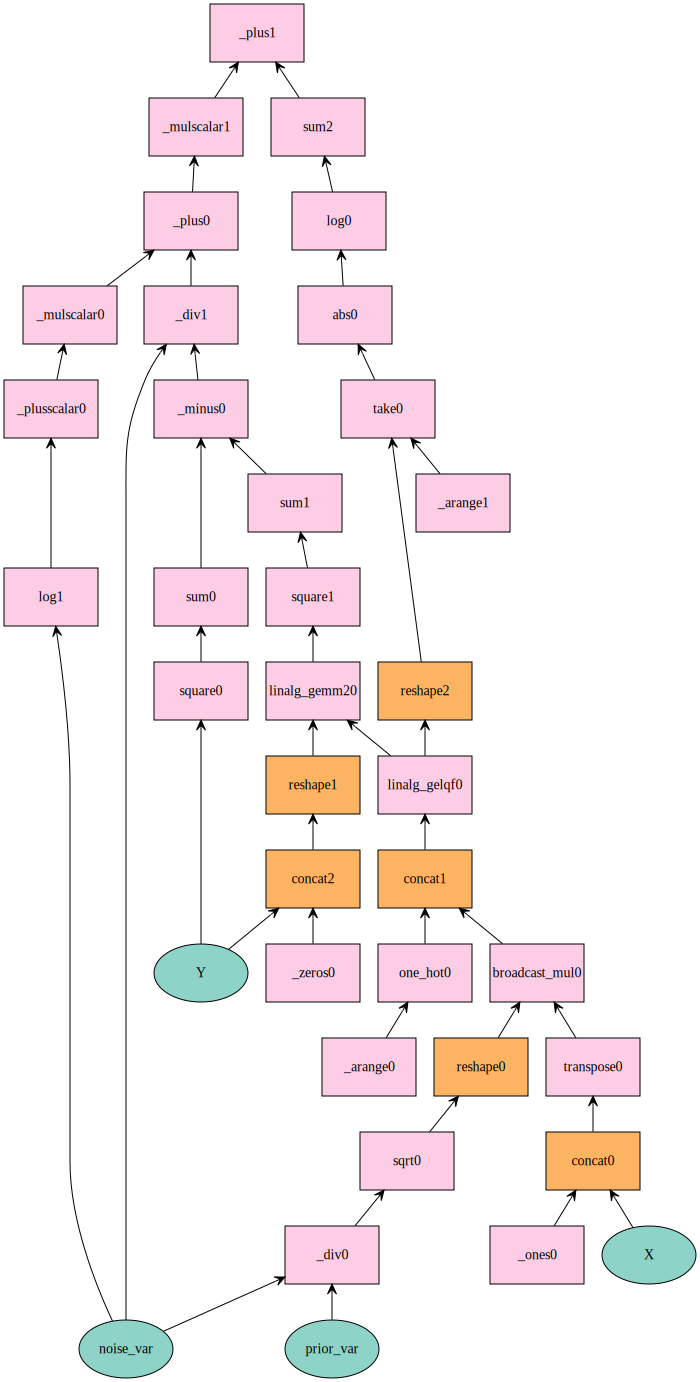

In [8]:
mx.viz.plot_network(m._sym_NlogL)

In [9]:
# Optimize the model hyper-parameters 
m.optimize('scg',messages=1)
print(m)

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s05  0006   6.520738e+01   9.495795e+03 
    00s09  0020  -7.682944e+01   1.047239e+01 
    00s19  0056  -7.749707e+01   1.983858e+00 
    01s04  1819  -7.832442e+01   1.814171e-03 
Runtime:     01s04
Optimization status: maxiter exceeded


Name : bayeslinregr
Objective : -78.32442804812287
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  bayeslinregr.  |            value  |  constraints  |  priors
  prior_var      |     3.8333315944  |      +ve      |        
  noise_var      |  0.0101335545811  |      +ve      |        


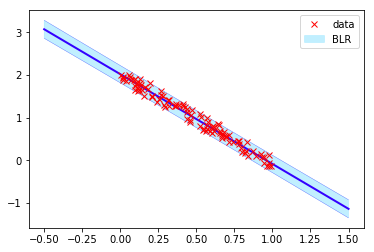

In [10]:
# Plot the prediction from the model
Xt = np.linspace(-0.5,1.5,100)[:,None]
pm,pv = m.predict(Xt)
fig = figure()
ax = fig.gca()
gpplot(Xt,pm, pm-1.98*np.sqrt(pv),pm+1.98*np.sqrt(pv),ax=ax,label='BLR')
ax.plot(X,Y,'rx',label='data')
ax.legend()

## Extension to Bayesian Polynomial Regression

With the above model, we can easily extend BLR into a polynomial regression by extending the feature matrix to be the polynomial basis functions.

In [11]:
class PolynomialRegression(BayesLinRegression):

    def __init__(self, X, Y, order, ctx=None, mx_dtype=np.float32, name='polyregr'):
        """Bayesian Polynomial Regression

        :param X: Numpy Array of inputs
        :param Y: Numpy Array of outputs
        :param order: The order of polynomials 
        :param ctx: MXNet Context (optional)
        :param mx_dtype: The float point type used in MXNet computation (np.float32 or np.float64) (optional)
        :param name: The name of the model (optional)
        """
        self.num_features = order +1
        super(PolynomialRegression, self).__init__(X=X, Y=Y, ctx=ctx, mx_dtype=mx_dtype, name=name)
        
    def _gen_features(self, X, num_cases, num_dim):
        return mx.sym.Concat(*[mx.sym.pow(X, i) for i in range(self.num_features)], dim=1)

We load a toy data, which is the gold medal winning times of Men's Marathon at each Olympic games, where $X$ stores the years of the games and $Y$ stores the time given in pace (minutes per kilometer).

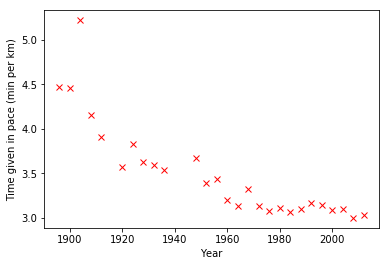

In [12]:
# Load 1D toy data
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y'][:,0]
plot(X, Y, 'rx')
xlabel('Year')
ylabel('Time given in pace (min per km)')

In [13]:
# Normalize the data
X_min = X.min()
X_max = X.max()
X_norm = (X-X_min)/(X_max-X_min)

In [14]:
# Instanize a model with the toy data
m = PolynomialRegression(X_norm, Y, 20, mx_dtype=np.float64)
print(m)


Name : polyregr
Objective : 177.55566919588426
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  polyregr.  |             value  |  constraints  |  priors
  prior_var  |               1.0  |      +ve      |        
  noise_var  |  0.00285998869872  |      +ve      |        


In [15]:
# Optimize the model hyper-parameters 
m.optimize(messages=1)
print(m)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   3.837983e+01   1.186603e+03 
    00s03  0010   1.285523e+01   1.967768e-01 
    00s05  0013   1.261632e+01   1.414589e-02 
    00s06  0016   1.261369e+01   2.524211e-08 
    00s19  0047   1.261369e+01   2.524211e-08 
    00s21  0055   1.261369e+01   2.524211e-08 
Runtime:     00s21
Optimization status: Converged


Name : polyregr
Objective : 12.613693981063697
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  polyregr.  |            value  |  constraints  |  priors
  prior_var  |    6.57401928463  |      +ve      |        
  noise_var  |  0.0525044240239  |      +ve      |        


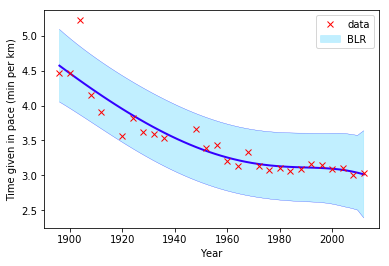

In [16]:
# Plot the prediction from the model
Xt = np.linspace(0,1,50)[:,None]
pm,pv = m.predict(Xt)
fig = figure()
ax = fig.gca()
gpplot(Xt*(X_max-X_min)+X_min,pm, pm-1.98*np.sqrt(pv),pm+1.98*np.sqrt(pv),ax=ax,label='BLR')
ax.plot(X,Y,'rx',label='data')
ax.legend()
xlabel('Year')
ylabel('Time given in pace (min per km)')